<a href="https://colab.research.google.com/github/TeaWithLucas/MLBirds/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import numpy as np
import re
import seaborn as sns
import operator
import math
from IPython import get_ipython
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')
    from imageio import imread, imwrite
from PIL import Image
import tqdm.notebook as tq #just to provide visual feedback

In [69]:
git_fldr = '/content/MLBirds/'

if os.path.exists(git_fldr):
  %cd '/content/MLBirds/'
  !git pull
else:
  !git clone https://github.com/TeaWithLucas/MLBirds.git
  %cd '/content/MLBirds/'

import data_load as data

/content/MLBirds
Already up to date.


In [70]:
img_fldr='images/'
process_fldr='processed/'
bound_fldr='bound/'

def get_image_path(image_id, fldr=img_fldr):
  rows = data.images.loc[data.images.image_id == image_id]
  return os.path.join(fldr,rows.image_name.values[0])
  
def get_image(image_id, fldr=img_fldr):
  path = get_image_path(image_id, fldr)
  return Image.open(path)

def get_cv2_image(image_id, flags=None, fldr=img_fldr):
  path = get_image_path(image_id, fldr)
  return cv2.imread(path)

def get_image_class_id(image_id):
  rows = data.image_class_labels.loc[data.images.image_id == image_id]
  return rows.class_id.values[0]

def get_class_name(class_id):
  rows = data.classes.loc[data.classes.class_id == class_id]
  return rows.class_name.values[0]

def get_image_class_name(image_id):
  return get_class_name(get_image_class_id(test_id))

def get_bounding_box(image_id):
  rows = data.bounding_boxes.loc[data.bounding_boxes.image_id == image_id]
  return rows

#Visualization picture
def plt_img(img):
    img=np.array(img)
    plt.imshow(img)
    plt.show()

       image_id                                         image_name
0             1  001.Black_footed_Albatross/Black_Footed_Albatr...
1             2  001.Black_footed_Albatross/Black_Footed_Albatr...
2             3  001.Black_footed_Albatross/Black_Footed_Albatr...
3             4  001.Black_footed_Albatross/Black_Footed_Albatr...
4             5  001.Black_footed_Albatross/Black_Footed_Albatr...
...         ...                                                ...
11783     11784  200.Common_Yellowthroat/Common_Yellowthroat_00...
11784     11785  200.Common_Yellowthroat/Common_Yellowthroat_00...
11785     11786  200.Common_Yellowthroat/Common_Yellowthroat_00...
11786     11787  200.Common_Yellowthroat/Common_Yellowthroat_00...
11787     11788  200.Common_Yellowthroat/Common_Yellowthroat_00...

[11788 rows x 2 columns]
     class_id              class_name
0           1  Black_footed_Albatross
1           2        Laysan_Albatross
2           3         Sooty_Albatross
3           4     

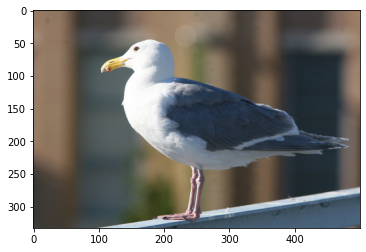

In [71]:
#testing imported data
print(data.images)
print(data.classes)
print(data.image_class_labels)
print(data.bounding_boxes)
print(data.train_test_split)
test_id = 3457
print(get_image_path(test_id))
print(get_image_class_name(test_id))
plt_img(get_image(test_id))


In [72]:
#get all images under each image category and check the image size and number of joints
def process_image_conformity(image_ids):
    for img_id in tq.tqdm(image_ids):
        new_path = get_image_path(img_id,process_fldr)
        #check if already processed
        if not os.path.exists(new_path):
          if not os.path.exists(os.path.dirname(new_path)):
            os.makedirs(os.path.dirname(new_path))
          cur_img = get_image(img_id,img_fldr)
          #picture needs resize?
          print('cur_img_id:',img_id,'img size：',cur_img.size,'img mode：',cur_img.mode)
          if cur_img.size[0]!=256 and cur_img.size[1]!=256: #should this be a or?
              cur_img=convertjpg(cur_img)
              print('cur_img_id:',img_id,'img size：',cur_img.size,'img mode：',cur_img.mode)
              #convert pic mode
              if(cur_img.mode!='RGB'):
                  cur_img=cur_img.convert('RGB')
                  print('cur_img_id:',img_id,'img size：',cur_img.size,'img mode：',cur_img.mode)
          #save picture to a new path
          cur_img.save(new_path)


    
#Convert the picture to a uniform size
def convertjpg(img,width=256,height=256):
    new_img=img.resize((width,height),Image.BILINEAR) 
    return new_img

    
process_image_conformity(data.images.image_id)
        

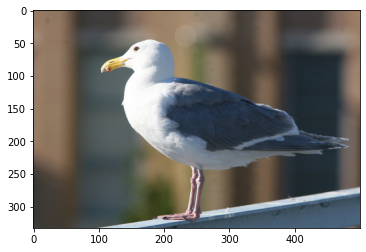

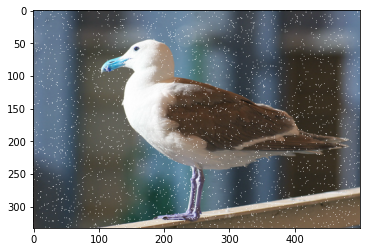

In [73]:
#Add random noise (actually, randomly change the gray value of pixels on the image to 255, which is white)
def random_noise(img_id,noise_num):
    img = get_cv2_image(img_id)
    img_noise = img
    rows, cols, chn = img_noise.shape
    for i in range(noise_num):
        x = np.random.randint(0, rows)
        y = np.random.randint(0, cols)
        img_noise[x, y, :] = 255
    return img_noise

for img_id in data.images.image_id[3456:3457]:
    plt_img(get_image(img_id))
    img_noise=random_noise(img_id,3000)
    plt_img(img_noise)

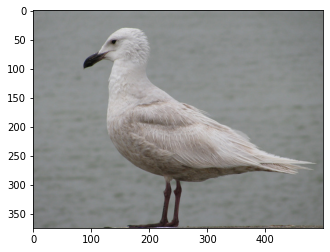

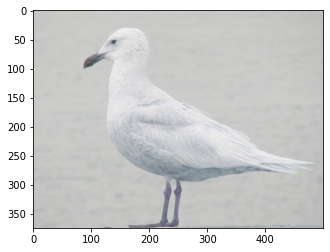

In [74]:
def gamma_transform(img_id):
    img = get_cv2_image(img_id,0)
    fi = img / 255.0
    gamma = 0.4
    out_img = np.power(fi, gamma)
    return out_img
    
for img_id in data.images.image_id[3474:3475]:
    plt_img(get_image(img_id))
    gamma_img=gamma_transform(img_id)
    plt_img(gamma_img)

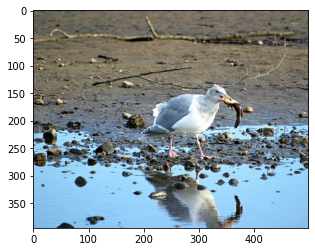

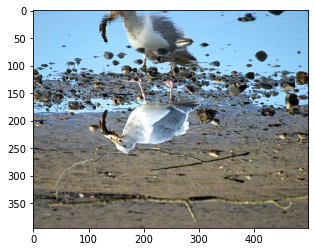

In [75]:
def pic_transpose(image):
    #transpose_img = img.transpose(Image.ROTATE_90)
    transpose_img = image.transpose(Image.ROTATE_180)
    #transpose_img = img.transpose(Image.ROTATE_270)
    return transpose_img

for img_id in data.images.image_id[3437:3438]:
    image = get_image(img_id)
    plt_img(image)
    transpose_img=pic_transpose(image)
    plt_img(transpose_img)

In [76]:
def get_imghist(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([img],[0],None,[256],[0,255])
    return hist

def cal_equalhist(img_id):
    img=get_cv2_image(img_id)
    if len(img.shape) == 3:
         img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    h,w = img.shape[:2]
    grathist = get_imghist(img)
 
    zerosumMoment = np.zeros([256],np.uint32)
    for p in range(256):
        if p ==0:
            zerosumMoment[p] = grathist[0]
        else:
            zerosumMoment[p] = zerosumMoment[p-1] +grathist[p]
 
    output_q = np.zeros([256],np.uint8)
    cofficient = 256.0/(h*w)
    for p in range(256):
        q = cofficient *float(zerosumMoment[p]) - 1
        if q >= 0:
            output_q[p] = math.floor(q)
        else:
            output_q[p] = 0
 
    equalhistimage = np.zeros(img.shape,np.uint8)
    for i in range(h):
        for j in range(w):
            equalhistimage[i][j] = output_q[img[i][j]]
    return equalhistimage



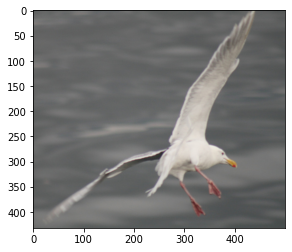

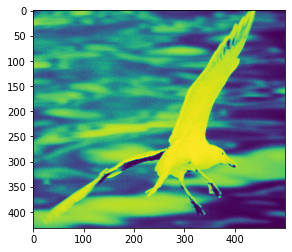

In [77]:
for img_id in data.images.image_id[3432:3433]:
    plt_img(get_image(img_id))
    transpose_img=cal_equalhist(img_id)
    plt_img(transpose_img)

In [78]:
def bound_image(img_id):
    img = get_cv2_image(img_id)
    bounding_box = get_bounding_box(img_id)
    #print(img_id,bounding_box)
    x = bounding_box.x.values[0]
    y = bounding_box.y.values[0]
    w = bounding_box.width.values[0]
    h = bounding_box.height.values[0]
    crop_img = img[y:y+h,x:x+w] #crops the image with respect to bounding boxes mentioned in the dataset
    return crop_img

def bound_images(image_ids):
    for img_id in tq.tqdm(image_ids):
        new_path = get_image_path(img_id,bound_fldr)
        #check if already processed
        if not os.path.exists(new_path):
          if not os.path.exists(os.path.dirname(new_path)):
            os.makedirs(os.path.dirname(new_path))
          cur_img = bound_image(img_id)
          cur_img = cv2.resize(cur_img, (128,128))
          #img = cv2.resize(crop_img, (276, 315))#resizing the cropped image so that all images have same dimensions and can easily be converted to np array 
          #also reduces the memory usage
          #took the average of all images to rezise (mean of x+width, y+height)
          #save picture to a new path
          cv2.imwrite(new_path,cur_img)

bound_images(data.images.image_id)

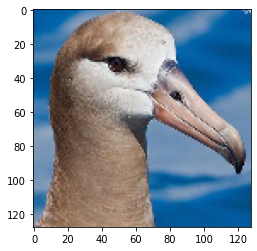

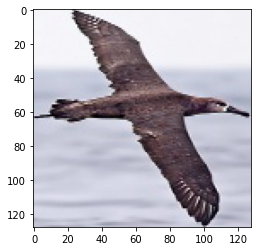

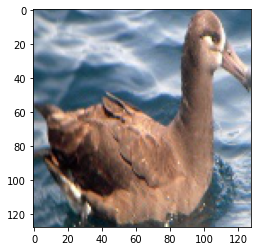

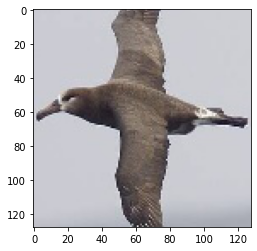

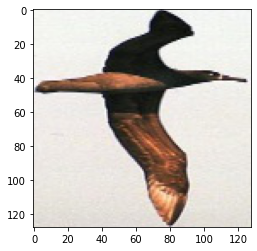

In [79]:
for img_id in tq.tqdm(data.images.image_id[0:5]):
  plt_img(get_image(img_id,bound_fldr))

In [80]:
#seperting testing and training data as given in the dataset
train_ids =[]
x_train_list =[]
y_train_list =[]
test_ids =[]
x_test_list =[]
y_test_list=[]


for row in tq.tqdm(data.train_test_split.itertuples(),total=len(data.train_test_split)):
  img_id = row.image_id
  if(row.is_training_image==0):
    train_ids.append(img_id)
    x_train_list.append(get_cv2_image(img_id, fldr=bound_fldr))
    y_train_list.append(get_image_class_id(img_id)-1) #to make the values start from 0 so that total values will be 200 when converting to catogerical
    
  else:
    test_ids.append(img_id)
    x_test_list.append(get_cv2_image(img_id,fldr=bound_fldr))
    y_test_list.append(get_image_class_id(img_id)-1)#to make the values start from 0 so that total values will be 200 when converting to catogerical



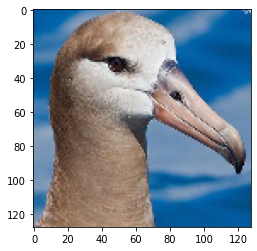

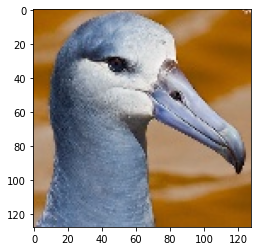

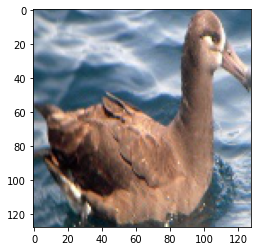

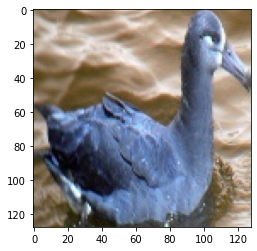

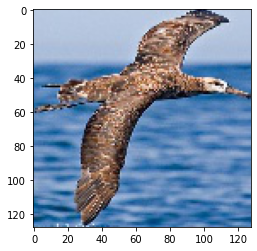

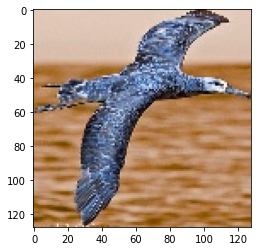

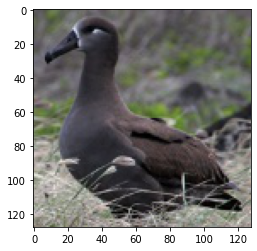

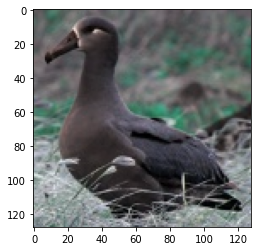

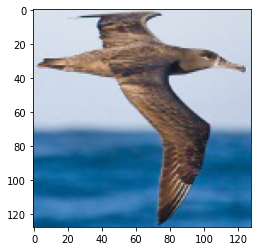

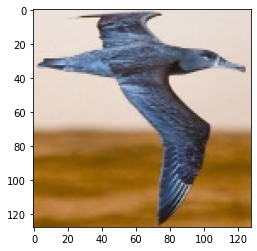

In [81]:
for i, img_id in tq.tqdm(enumerate(train_id[0:5])):
  plt_img(get_image(img_id,bound_fldr))
  plt_img(x_train_list[i])

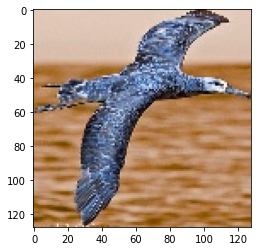

In [82]:
plt.imshow(x_train_list[2])

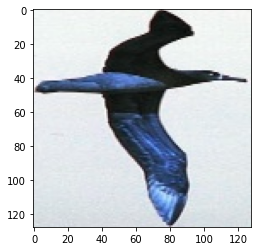

In [83]:
plt.imshow(x_test_list[2])

In [84]:
#dont run this if running the below (*****) cell
x_train = np.array(x_train_list, np.float32)#converting the images to np array

In [85]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train_list) #converting the class_id vectors to matrix form

In [86]:
x_test = np.array(x_test_list, np.float32)#converting the images to np array
y_test = to_categorical(y_test_list) #converting the class_id vectors to matrix form

In [87]:
#creating 90%test set and 10%developlement set from x_test, y_test
from sklearn.model_selection import train_test_split
x_test,x_develope,y_test,y_develope = train_test_split(x_test,y_test, train_size = 0.9, random_state = 1)

In [88]:
#defining number of classes and callbacks
n_classes = 200
from keras.callbacks import ModelCheckpoint
filepath = 'drive/My Drive/AML/group_project/my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


In [89]:
#using pretrained EfficientNetB7 model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import argparse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [90]:
#prining shapes of developement set and test set
#no need to run this if  you are not using the whole data set,(running the cell *****)
print(x_develope.shape)
print(y_develope.shape)

(600, 128, 128, 3)
(600, 200)


In [91]:
base_model = keras.applications.EfficientNetB7(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
x= layers.Flatten()(avg)
output = keras.layers.Dense(n_classes, activation="sigmoid")(x)
model = keras.Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, None, None, 3 7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_2[0][0]            
____________________________________________________________________________________________

In [92]:
for layer in base_model.layers:
  layer.trainable = False
#optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.01)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
#history =model.fit(x_train,y_train, batch_size=100, epochs=25, validation_data=(x_develope,y_develope),callbacks=[checkpoint])
#please run the above line if you train for whole dataset else just run it without any changes
#make the below line as a comment if u dont run the cell(*****)
history =model.fit(x_train,y_train, batch_size=50, epochs=25, validation_split=0.1 ,callbacks=[checkpoint] )

Epoch 1/25


KeyboardInterrupt: ignored